In [ ]:
import numpy as np
from datetime import datetime

Parameters

In [ ]:
# Pricing date
pricing_date = datetime(2025, 1, 23)

# Need adjustment
# Dividend Payment Dates
dividend_dates = [
    datetime(2025, 2, 20),
    datetime(2025, 5, 22),
    datetime(2025, 8, 21),
    datetime(2025, 11, 20)
]

TD = [(div_date - pricing_date).days / 365 for div_date in dividend_dates]

for i, interval in enumerate(TD):
    print(f"Dividend Date {dividend_dates[i].strftime('%Y-%m-%d')} -> T = {interval:.4f} years")


Dividend Date 2025-02-20 -> T = 0.0767 years
Dividend Date 2025-05-22 -> T = 0.3260 years
Dividend Date 2025-08-21 -> T = 0.5753 years
Dividend Date 2025-11-20 -> T = 0.8247 years


In [ ]:
# Observation Dates
obs_dates = [
    datetime(2025, 4, 23),
    datetime(2025, 7, 23),
    datetime(2025, 10, 23),
]

obs_times  = [(obs_date - pricing_date).days / 365 for obs_date in obs_dates]

for i, interval in enumerate(obs_times ):
    print(f"Observation Date {obs_dates[i].strftime('%Y-%m-%d')} -> T = {interval:.4f} years")


Observation Date 2025-04-23 -> T = 0.2466 years
Observation Date 2025-07-23 -> T = 0.4959 years
Observation Date 2025-10-23 -> T = 0.7479 years


In [ ]:
# Coupon Payment Dates
coupon_dates = [
    datetime(2025, 4, 28),
    datetime(2025, 7, 28),
    datetime(2025, 10, 28),
]

coupon_times  = [(coupon_date - pricing_date).days / 365 for coupon_date in coupon_dates]

for i, interval in enumerate(coupon_times ):
    print(f"Coupon Payment Date {coupon_dates[i].strftime('%Y-%m-%d')} -> T = {interval:.4f} years")


Coupon Payment Date 2025-04-28 -> T = 0.2603 years
Coupon Payment Date 2025-07-28 -> T = 0.5096 years
Coupon Payment Date 2025-10-28 -> T = 0.7616 years


In [ ]:
N = 1000 #Could be adjusted
S0 = 190.7
sigma = (37.577+37.462+37.897+37.797)/4/100
r = (4.19362+4.20058)/2/100 # Need data
T =  (datetime(2026, 1, 23)-pricing_date).days/365
# Dividend
D = [0.0091/4, 0.0107/4, 0.0107/4, 0.0107/4] # data from Bloomberg

In [ ]:
# Note parameters
face = 10.0
auto_call_barrier = 190.7       # Autocall trigger price
coupon_barrier = 123.96
conversion_barrier = 123.96      # Conversion threshold at maturity
coupon = face * (0.1135/4)      # Payment

note_parameters = (face, auto_call_barrier, coupon_barrier, conversion_barrier, coupon)

Stock Value Tree

In [ ]:
def Stock_tree(N, S0, sigma, r, T, D, TD):

    S = np.zeros([N+1, N+1])

    Dt = T / N
    u = np.exp(r*Dt + sigma * (Dt)**0.5)
    d = np.exp(r*Dt - sigma * (Dt)**0.5)
    #print("u = ", u, "d=", d)

    # FIRST LET'S BUILD A STOCK PRICE TREE WITH DIVIDENDS
    # Let's have dividends at grid points rather than times

    iD1 = [i/Dt for i in TD]
    iD = [np.ceil(i) for i in iD1]
    print(iD)

    S[0,0] = S0
    num_D = 0
    for i in range (1,N+1):
        S[i, 0] = S[i-1, 0]*d
        for j in range(1, i+1):
            S[i, j] = S[i-1, j-1]*u

    # This adjusts all stock prices for that i by the size of the dividend
        if i in iD:
          S[i, :] *= (1-D[num_D])
          num_D += 1
    # print(S[3,0], S[4,0], S[50,50])
    return S

Pricing

In [ ]:
def price_EL_note(N, S0, sigma, r, T, D, TD, coupon_times, obs_times, note_parameters):
    # 1. Construct the stock price binomial tree (adjusted for dividends)
    S = Stock_tree(N, S0, sigma, r, T, D, TD)

    dt = T / N
    # Compute binomial tree parameters (consistent with Stock_tree function)
    u = np.exp(r*dt + sigma * np.sqrt(dt))
    d = np.exp(r*dt - sigma * np.sqrt(dt))
    q = (np.exp(r*dt) - d) / (u - d)

    # 2. Define note parameters
    face, auto_call_barrier, coupon_barrier, conversion_barrier, coupon = note_parameters

    # 3. Convert coupon and observation dates to binomial tree step indices
    coupon_indices = [int(np.ceil(t/dt)) for t in coupon_times]
    obs_indices = [int(np.ceil(t/dt)) for t in obs_times]
    # print("Coupon payment steps:", coupon_indices)
    # print("Observation steps:", obs_indices)

    # 4. Initialize the note value tree with dimensions (N+1) x (N+1)
    V = np.zeros((N+1, N+1))

    # 5. Determine note payoff at maturity (including final coupon)
    for j in range(N+1):
        if S[N, j] >= conversion_barrier:
            V[N, j] = (face + coupon)*np.exp(-r*(5/365/N))  # Full face value + final coupon payment
        else:
            # If stock price falls below the conversion threshold, apply conversion ratio and add final coupon
            conversion_ratio =  S[N, j]/S0
            # print(S0, S[N, j], conversion_ratio)
            V[N, j] = (face * conversion_ratio)*np.exp(-r*(5/365/N))

    # 6. Perform backward induction to compute the note value at each node
    for i in range(N-1, -1, -1):
        for j in range(i+1):
            # Compute expected discounted future value
            cont_value = np.exp(-r*dt) * (q * V[i+1, j+1] + (1-q) * V[i+1, j])
            # If current step is a coupon payment date, check coupon condition, then add coupon
            if i in coupon_indices and S[i, j] >= coupon_barrier:
                cont_value += coupon
            # If current step is an observation date, check autocall condition
            if i in obs_indices and S[i, j] >= auto_call_barrier:
                # Autocall: Immediately redeem the note and pay face value + current coupon
                auto_call_payoff = (face + coupon)*np.exp(-r*(5/365/N))
                V[i, j] = auto_call_payoff
            else:
                V[i, j] = cont_value
    return V[0, 0]

In [ ]:
note_price = price_EL_note(N, S0, sigma, r, T, D, TD, coupon_times, obs_times, note_parameters)

u =  1.012030249231736 d= 0.988195704903508
[77.0, 327.0, 576.0, 825.0]
Coupon payment steps: [261, 510, 762]
Observation steps: [247, 496, 748]


In [ ]:
print("TACY Note Price =", note_price)

TACY Note Price = 9.785529329894386


In [ ]:
# 计算 Lambda
def compute_lambda_barrier(S_T, B):
    below_indices = np.where(S_T <= B)[0]
    if len(below_indices) == 0:
        return np.nan

    j = below_indices[-1]
    if j == len(S_T) - 1:
        return np.nan

    S_below = S_T[j]
    S_above = S_T[j + 1]

    if abs(S_above - S_below) < 1e-15:
        return np.nan

    Lambda = (S_above - B) / (S_above - S_below)
    return Lambda

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


# 取不同的 N 值
Ns = np.arange(50, 1001, 10)
prices_lr = []
errors_lr = []
lambdas = []

# 理论价格
true_price = 9.76

# 计算不同 N 对应的价格、误差和 Lambda
for N in Ns:
    priceN = price_EL_note(N, S0, sigma, r, T, D, TD, coupon_times, obs_times, note_parameters)
    errN = (priceN / true_price - 1.0) if true_price != 0 else 0.0
    S_tree = Stock_tree(N, S0, sigma, r, T, D, TD)
    S_T = S_tree[N, :]  # 终端股价路径
    B = S0  # 触发屏障
    lamN = [compute_lambda_barrier(S_T, B) for t in obs_times]

    prices_lr.append(priceN)
    errors_lr.append(errN)
    lambdas.append(lamN)

errors_lr = np.array(errors_lr)
lambdas = np.array(lambdas)


[4.0, 17.0, 29.0, 42.0]
[4.0, 17.0, 29.0, 42.0]
[5.0, 20.0, 35.0, 50.0]
[5.0, 20.0, 35.0, 50.0]
[6.0, 23.0, 41.0, 58.0]
[6.0, 23.0, 41.0, 58.0]
[7.0, 27.0, 47.0, 66.0]
[7.0, 27.0, 47.0, 66.0]
[7.0, 30.0, 52.0, 75.0]
[7.0, 30.0, 52.0, 75.0]
[8.0, 33.0, 58.0, 83.0]
[8.0, 33.0, 58.0, 83.0]
[9.0, 36.0, 64.0, 91.0]
[9.0, 36.0, 64.0, 91.0]
[10.0, 40.0, 70.0, 99.0]
[10.0, 40.0, 70.0, 99.0]
[10.0, 43.0, 75.0, 108.0]
[10.0, 43.0, 75.0, 108.0]
[11.0, 46.0, 81.0, 116.0]
[11.0, 46.0, 81.0, 116.0]
[12.0, 49.0, 87.0, 124.0]
[12.0, 49.0, 87.0, 124.0]
[13.0, 53.0, 93.0, 132.0]
[13.0, 53.0, 93.0, 132.0]
[14.0, 56.0, 98.0, 141.0]
[14.0, 56.0, 98.0, 141.0]
[14.0, 59.0, 104.0, 149.0]
[14.0, 59.0, 104.0, 149.0]
[15.0, 62.0, 110.0, 157.0]
[15.0, 62.0, 110.0, 157.0]
[16.0, 66.0, 116.0, 165.0]
[16.0, 66.0, 116.0, 165.0]
[17.0, 69.0, 121.0, 174.0]
[17.0, 69.0, 121.0, 174.0]
[17.0, 72.0, 127.0, 182.0]
[17.0, 72.0, 127.0, 182.0]
[18.0, 75.0, 133.0, 190.0]
[18.0, 75.0, 133.0, 190.0]
[19.0, 79.0, 139.0, 198.0]
[19

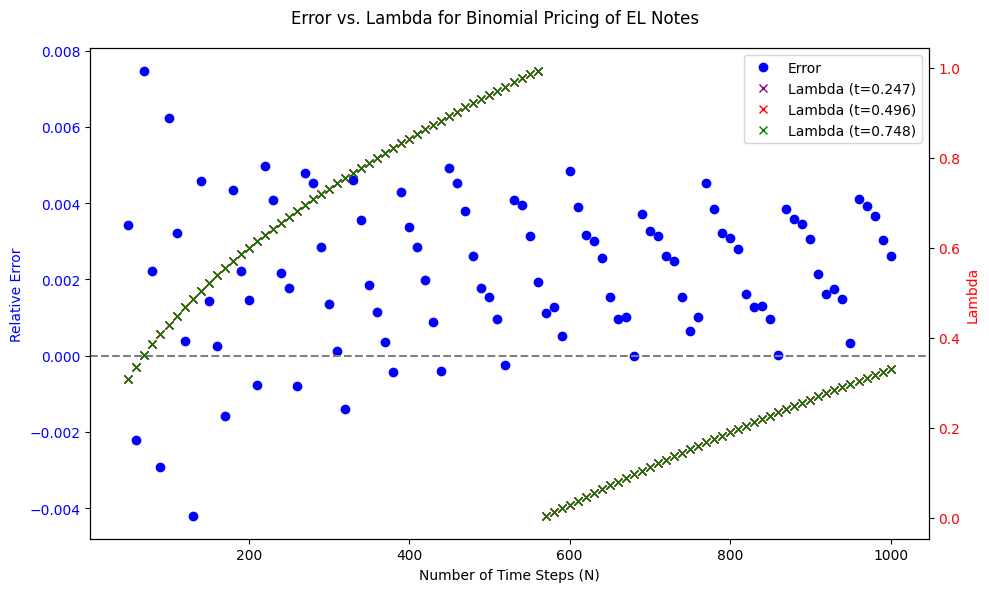

In [ ]:

# 绘制 Lambda 和 Price Error 在同一张图上
fig, ax1 = plt.subplots(figsize=(10, 6))

# Relative Error 曲线
color_err = 'blue'
ax1.set_xlabel("Number of Time Steps (N)")
ax1.set_ylabel("Relative Error", color=color_err)
ax1.plot(Ns, errors_lr, marker='o', linestyle='', color=color_err, label="Error")
ax1.axhline(0, color='gray', linestyle='--')
ax1.tick_params(axis='y', labelcolor=color_err)

# Lambda 曲线
ax2 = ax1.twinx()
ax2.set_ylabel("Lambda", color='red')
ax2.tick_params(axis='y', labelcolor='red')

colors = ['purple', 'red', 'green', 'orange']
for i, t in enumerate(obs_times):
    ax2.plot(Ns, lambdas[:, i], marker='x', linestyle='',
              color=colors[i % len(colors)],
              label=f"Lambda (t={t:.3f})")

# 合并图例
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='best')

fig.suptitle("Error vs. Lambda for Binomial Pricing of EL Notes")
fig.tight_layout()
plt.show()